In [1]:
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.externals import joblib
import matplotlib.pyplot as plt
# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Bank client Data
1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')
- related with the last contact of the current campaign:
8. contact: contact communication type (categorical: 'cellular','telephone') 
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric) 
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
19.  euribor3m: euribor 3 month rate - daily indicator (numeric)
20.  nr.employed: number of employees - quarterly indicator (numeric)

# Output variable (desired target):
21. y - has the client subscribed a term deposit? (binary: 'yes','no')

In [2]:

# Load the marketing data
data = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';', engine='python')
display(data.head(n=1))
data.dtypes

age        job  marital education default housing loan    contact month  \
0   56  housemaid  married  basic.4y      no      no   no  telephone   may   

  day_of_week ...  campaign  pdays  previous     poutcome emp.var.rate  \
0         mon ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  

[1 rows x 21 columns]

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123839048>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x123876ac8>]], dtype=object)

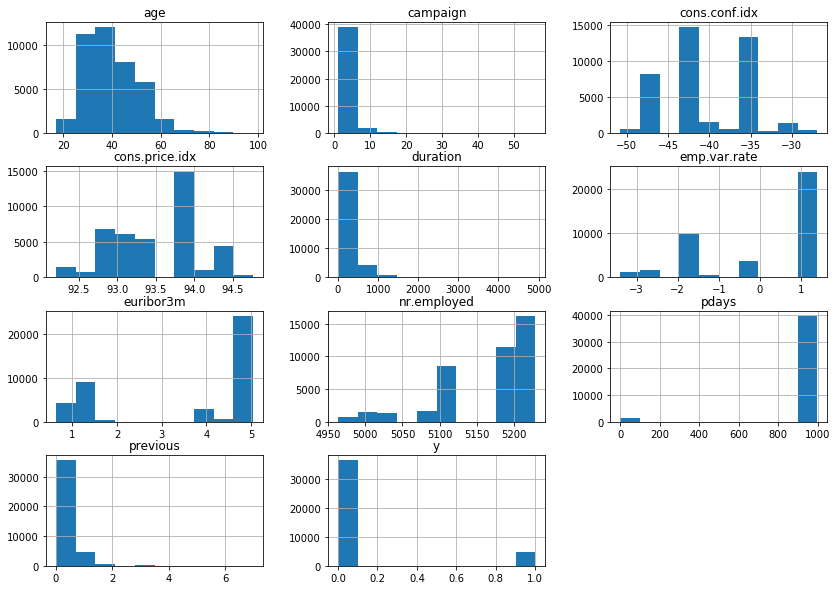

In [88]:
data.hist(figsize=(14,10))

In [89]:
data['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

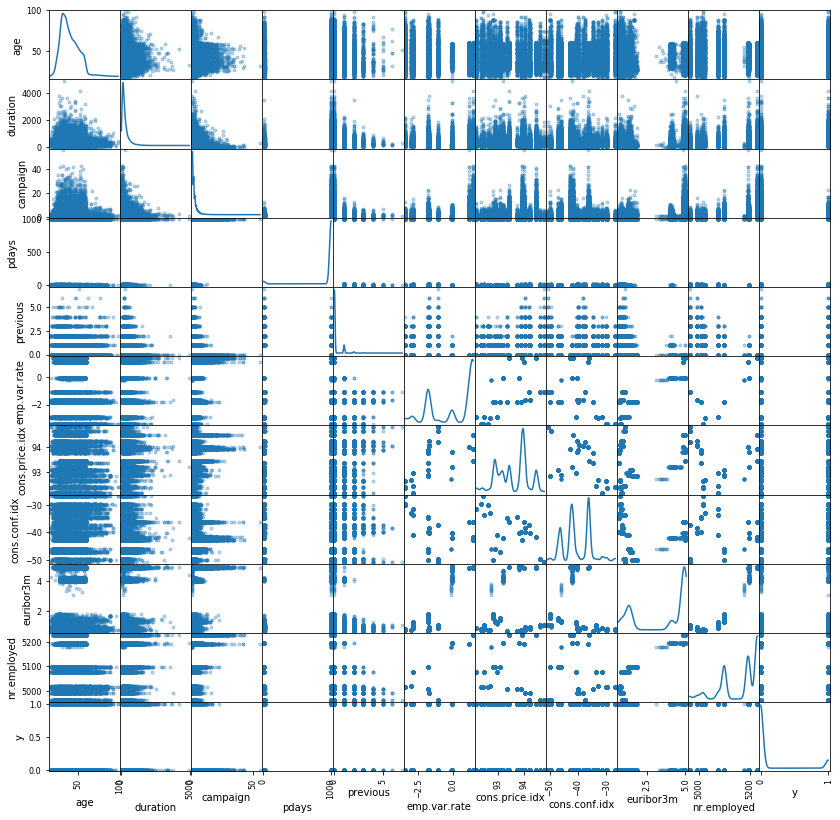

In [90]:
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,14), diagonal = 'kde');

In [91]:
fig = plt.figure(1, figsize=(9, 6))
ax1 = fig.add_subplot(211)
bp1 = ax1.boxplot(data.age,0,'')
ax2 = fig.add_subplot(212)
bp2 = ax2.boxplot(data.duration,0,'gD')
plt.show()

In [3]:
#  Total number of records
n_records = len(data.index)
n_records
list(data)


['age',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
 'y']

# Analyze the data

In [4]:

data['y'] = np.where(data['y']=='yes', 1, 0)
#data['housing'] = np.where(data['housing']=='yes', 1, 0)
#data['loan'] = np.where(data['loan']=='yes', 1, 0)
#data['contact'] = np.where(data['contact']=='cellular', 1, 0)
#data['poutcome'] = np.where(data['poutcome']=='success', 1, 0)
decision =data['y']

features_raw = data.drop('y', axis = 1)
display(features_raw.head(n = 5))
#display(data.head(n = 5))

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  duration  campaign  pdays  previous     poutcome  \
0   may         mon       261         1    999         0  nonexistent   
1   may         mon       149         1    999         0  nonexistent   
2   may         mon       226         1    999         0  nonexistent   
3   may         mon       151         1    999         0  nonexistent   
4   may         mon       307         1    999         0  nonexistent   

   emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed  
0           1.1          93.994          -36.4      4.857       5191.0  
1           1.1          93.994          -36.4      4.857       5191.0  
2           1.1          93.994          -36.4      4.857       5191.0  
3           1.1          93.994          -36.4      4.857       5191.0  
4           1.1          93.994          -36.4      4.857       5191.0

# MinMax Scaler to normalize the data

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'campaign','duration' ,'pdays','emp.var.rate','previous', 'cons.price.idx','cons.conf.idx','euribor3m','nr.employed']

features_minmax_transform = pd.DataFrame(features_raw)
features_minmax_transform[numerical] = scaler.fit_transform(features_minmax_transform[numerical])

# Show an example of a record with scaling applied
display(features_minmax_transform.head(n = 5))

age        job  marital    education  default housing loan    contact  \
0  0.481481  housemaid  married     basic.4y       no      no   no  telephone   
1  0.493827   services  married  high.school  unknown      no   no  telephone   
2  0.246914   services  married  high.school       no     yes   no  telephone   
3  0.283951     admin.  married     basic.6y       no      no   no  telephone   
4  0.481481   services  married  high.school       no      no  yes  telephone   

  month day_of_week  duration  campaign  pdays  previous     poutcome  \
0   may         mon  0.053070       0.0    1.0       0.0  nonexistent   
1   may         mon  0.030297       0.0    1.0       0.0  nonexistent   
2   may         mon  0.045954       0.0    1.0       0.0  nonexistent   
3   may         mon  0.030704       0.0    1.0       0.0  nonexistent   
4   may         mon  0.062424       0.0    1.0       0.0  nonexistent   

   emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed  
0        0.9375        0.698753        0.60251   0.957379     0.859735  
1        0.9375        0.698753        0.60251   0.957379     0.859735  
2        0.9375        0.698753        0.60251   0.957379     0.859735  
3        0.9375        0.698753        0.60251   0.957379     0.859735  
4        0.9375        0.698753        0.60251   0.957379     0.859735

# One hot encoding

In [6]:
#One hot encoding
features_final = pd.get_dummies(features_minmax_transform)
# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
encoded
#len(encoded)



['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
 'job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'marital_unknown',
 'education_basic.4y',
 'education_basic.6y',
 'education_basic.9y',
 'education_high.school',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'education_unknown',
 'default_no',
 'default_unknown',
 'default_yes',
 'housing_no',
 'housing_unknown',
 'housing_yes',
 'loan_no',
 'loan_unknown',
 'loan_yes',
 'contact_cellular',
 'contact_telephone',
 'month_apr',
 'month_aug',
 'month_dec',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'day_of_week_fri',
 'day_

In [7]:
display(features_final.head(n=1))

age  duration  campaign  pdays  previous  emp.var.rate  \
0  0.481481   0.05307       0.0    1.0       0.0        0.9375   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed        ...         \
0        0.698753        0.60251   0.957379     0.859735        ...          

   month_oct  month_sep  day_of_week_fri  day_of_week_mon  day_of_week_thu  \
0          0          0                0                1                0   

   day_of_week_tue  day_of_week_wed  poutcome_failure  poutcome_nonexistent  \
0                0                0                 0                     1   

   poutcome_success  
0                 0  

[1 rows x 63 columns]

# split the data 

In [8]:
 #Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    decision, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 32950 samples.
Testing set has 8238 samples.


/Users/owm075/anaconda/envs/aind-dl/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end-start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end-start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, average='binary', beta=0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, average='binary', beta=0.5)
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [10]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
# TODO: Initialize the three models
clf_A = AdaBoostClassifier(random_state = 0)
clf_B = svm.SVC(random_state = 0)
clf_C = GaussianNB()

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100
# HINT: samples_1 is 1% of samples_100
samples_100 = len(y_train)
samples_10 = int(samples_100*10/100)
samples_1 = int(samples_100*1/100)
# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

joblib.dump(clf_A, 'saved_models/AdaBooster_model.pkl')
joblib.dump(clf_B, 'saved_models/SVM_model.pkl')
joblib.dump(clf_C, 'saved_models/Gaussian_model.pkl')

AdaBoostClassifier trained on 329 samples.
AdaBoostClassifier trained on 3295 samples.
AdaBoostClassifier trained on 32950 samples.
SVC trained on 329 samples.


/Users/owm075/anaconda/envs/aind-dl/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 3295 samples.
SVC trained on 32950 samples.
GaussianNB trained on 329 samples.
GaussianNB trained on 3295 samples.
GaussianNB trained on 32950 samples.


['saved_models/Gaussian_model.pkl']

# Compare the models using the plot

In [11]:
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
def visualize_result(results):
    fig, ax = pl.subplots(2, 3, figsize = (11,7))
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
            for i in np.arange(3):
                ax[int(j/3), int(j%3)].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[int(j/3), int(j%3)].set_xticks([0.45, 1.45, 2.45])
                ax[int(j/3), int(j%3)].set_xticklabels(["1%", "10%", "100%"])
                ax[int(j/3), int(j%3)].set_xlabel("Training Set Size")
                ax[int(j/3), int(j%3)].set_xlim((-0.1, 3.0))
                
     # Add unique y-label
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")    

    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))
    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    pl.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
                   loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')

        # Aesthetics
    pl.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    pl.tight_layout()
    pl.show()

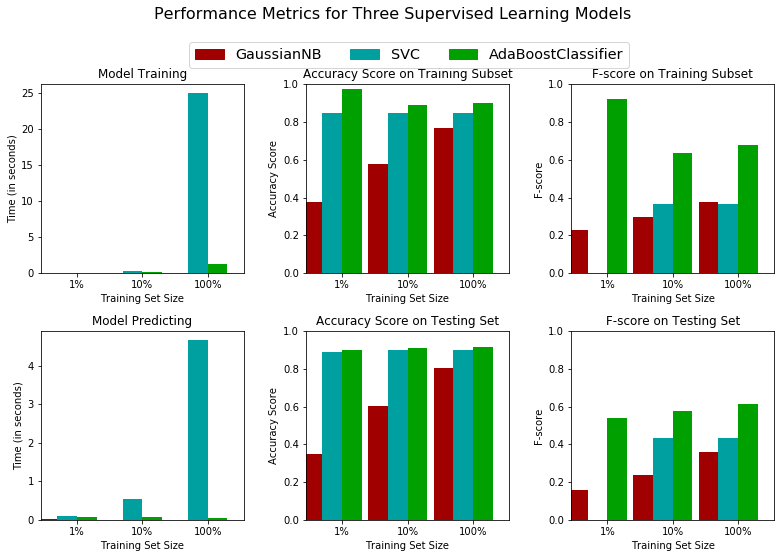

In [12]:
visualize_result(results)

In [13]:
#Improve model
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from scipy.stats import randint
from sklearn.ensemble import AdaBoostClassifier
# TODO: Initialize the classifier
clf = AdaBoostClassifier(random_state = 1)


# TODO: Create the parameters list you wish to tune
parameters = {'n_estimators' : [50,75,100,200], 'learning_rate' : [0.5,0.8,1,1.2]}


# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
display(pd.DataFrame(grid_obj.grid_scores_))

/Users/owm075/anaconda/envs/aind-dl/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Unoptimized model
------
Accuracy score on testing data: 0.9142
F-score on testing data: 0.6121

Optimized Model
------
Final accuracy score on the testing data: 0.9168
Final F-score on the testing data: 0.6281


parameters  mean_validation_score  \
0    {'learning_rate': 0.5, 'n_estimators': 50}               0.566940   
1    {'learning_rate': 0.5, 'n_estimators': 75}               0.570566   
2   {'learning_rate': 0.5, 'n_estimators': 100}               0.567642   
3   {'learning_rate': 0.5, 'n_estimators': 200}               0.572500   
4    {'learning_rate': 0.8, 'n_estimators': 50}               0.570270   
5    {'learning_rate': 0.8, 'n_estimators': 75}               0.578308   
6   {'learning_rate': 0.8, 'n_estimators': 100}               0.579329   
7   {'learning_rate': 0.8, 'n_estimators': 200}               0.586709   
8      {'learning_rate': 1, 'n_estimators': 50}               0.579606   
9      {'learning_rate': 1, 'n_estimators': 75}               0.582496   
10    {'learning_rate': 1, 'n_estimators': 100}               0.585060   
11    {'learning_rate': 1, 'n_estimators': 200}               0.585149   
12   {'learning_rate': 1.2, 'n_estimators': 50}               0.579364   
13   {'learning_rate': 1.2, 'n_estimators': 75}               0.582334   
14  {'learning_rate': 1.2, 'n_estimators': 100}               0.583895   
15  {'learning_rate': 1.2, 'n_estimators': 200}               0.581256   

                                cv_validation_scores  
0   [0.560416174036, 0.575284090909, 0.565119760479]  
1    [0.564006552773, 0.58488372093, 0.562807881773]  
2   [0.558529206423, 0.574884792627, 0.569512195122]  
3    [0.567202422548, 0.57253649635, 0.577761627907]  
4   [0.567731405922, 0.570319849483, 0.572759315206]  
5   [0.574594471099, 0.576748410536, 0.583580613254]  
6    [0.58304696449, 0.573108856089, 0.581831831832]  
7   [0.585021625313, 0.586151736746, 0.588954056696]  
8   [0.572641725958, 0.582191780822, 0.583986287953]  
9   [0.577049901077, 0.587831655993, 0.582606589147]  
10   [0.576199955762, 0.588636363636, 0.59034416826]  
11   [0.57799598304, 0.584532374101, 0.592918250951]  
12  [0.572268717485, 0.586214539007, 0.579608938547]  
13  [0.571587125416, 0.583188531712, 0.592228464419]  
14  [0.583425414365, 0.584532374101, 0.583726415094]  
15  [0.579038171231, 0.581238779174, 0.583491461101]

# Optimize the Ada Boost Model

In [14]:
#Feature importance
from sklearn.ensemble import AdaBoostClassifier

# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier(random_state = 1)
model.fit(X_train, y_train)
# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

In [15]:
from sklearn.cross_validation import train_test_split
# keras does not take pandas dataframe. Use numpy array instead.
X_Neural_train, X_Neural_test, y_Neural_train, y_Neural_test = train_test_split(X_train.values, y_train.values,
                                                              test_size=0.2, random_state = 20)
X_Neural_train.shape

(26360, 63)

# Artificial Neural Network

In [16]:
#Neural Network 

from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation

model = Sequential()
model.add(Dense(64, activation='sigmoid', input_shape=(63,)))
model.add(Dropout(.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(.2))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 6,721
Trainable params: 6,721
Non-trainable params: 0
_________________________________________________________________


# Calculate the recall and precision

In [17]:
from keras import backend as K

def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [18]:
#compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',precision,recall])

In [19]:
from keras.callbacks import ModelCheckpoint 
checkpointer = ModelCheckpoint(filepath='saved_models/bank_telemarketing_neural_network.hdf5',
                               verbose=1, save_best_only=False)
epochs=50
# Fit the model
model.fit(X_Neural_train, y_Neural_train, 
          validation_data=(X_Neural_test, y_Neural_test),
          epochs=epochs, batch_size=40, callbacks=[checkpointer], verbose=1)
#y_train.shape

Train on 26360 samples, validate on 6590 samples
Epoch 1/50
26360/26360 [==============================] - 3s 97us/step - loss: 0.3590 - acc: 0.8775 - precision: 0.0017 - recall: 0.0107 - val_loss: 0.3071 - val_acc: 0.8885 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
26360/26360 [==============================] - 2s 86us/step - loss: 0.2831 - acc: 0.8950 - precision: 0.4193 - recall: 0.1846 - val_loss: 0.2780 - val_acc: 0.8962 - val_precision: 0.4492 - val_recall: 0.2018
Epoch 3/50
26360/26360 [==============================] - 2s 85us/step - loss: 0.2716 - acc: 0.8961 - precision: 0.5151 - recall: 0.2591 - val_loss: 0.2683 - val_acc: 0.8982 - val_precision: 0.4876 - val_recall: 0.2278
Epoch 4/50
26360/26360 [==============================] - 2s 83us/step - loss: 0.2607 - acc: 0.8980 - precision: 0.5333 - recall: 0.2900 - val_loss: 0.2520 - val_acc: 0.9000 - val_precision: 0.4943 - val_recall: 0.2254
Epoch 5/50
26360/26360 [==============================] - 2s 79us/s

In [20]:
# evaluate the model
scores = model.evaluate(X_test.values, y_test.values)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

8238/8238 [==============================] - 0s 35us/step

acc: 92.15%


In [21]:
precision=scores[2]
recall=scores[3]

In [22]:
fscore_neural_net = 2*((precision*recall)/(precision+recall))

In [23]:
fscore_neural_net

0.59408639451196965

<Container object of 1 artists>

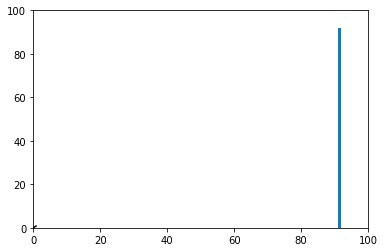

In [99]:

fig = plt.figure()
#plt.xlabel('Accuracy')
#plt.ylabel('Fscore')
s = fig.add_subplot(111)
plt.axis([0,100,0,100])
plt.plot([0,1],[0,1], 'k--')
s.bar([91.42], [92.05], width=1)
#s.set_xlim(0.5, 3.5)


# Roc curve comparison

In [100]:
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
def draw_roc_curve(model,X,y,roc_scores,model_name=None,):
    probas = model.predict_proba(X)
    if(model_name=="Neural_Network"):
        fpr, tpr, thresholds = roc_curve(y, probas[:, 0])
    else:
        fpr, tpr, thresholds = roc_curve(y, probas[:, 1])
    plt.plot(fpr, tpr, label=model_name)
    plt.plot([0,1],[0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    roc_scores[model_name ]= auc(fpr,tpr)

In [87]:
roc_scores=dict()
draw_roc_curve(model,X_Neural_test,y_Neural_test,roc_scores,"Neural_Network")
draw_roc_curve(clf,X_test,y_test,roc_scores,"Adabooster optimized")


plt.title('ROC chart')
plt.legend(loc='lower right')

In [58]:
roc_scores 

{'Neural_Network': 0.94175499747294311, 'adabooster': 0.9429928900007003}